In [1]:
%matplotlib inline

In [2]:
#%matplotlib notebook
#import multiprocessing as mp
#mp.set_start_method('forkserver')
import os
os.environ["CUDA_VISIBLE_DEVICES"] = '0'#, 1, 2, 3'

In [3]:
import torch.nn.functional as F
import torch
#torch.cuda.set_device(2)
import torch.nn as nn
from torch.nn.utils import weight_norm, spectral_norm
from tqdm import tqdm_notebook as tqdm
from collections import Counter
import numpy as np
from matplotlib import pyplot as plt
from torch.optim import *
from InvertibleResnet import *
import torch.multiprocessing as mp
import torch.distributed as dist
import torch.nn.parallel
import torch.backends.cudnn as cudnn
cudnn.deterministic = True
n_gpus = torch.cuda.device_count()


In [4]:
import torchvision
import torchvision.transforms as transforms
transform = transforms.Compose(
    [  transforms.Pad(2),
        transforms.ToTensor(), 
     transforms.Normalize((0.5,), (0.5,))])
     #transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.MNIST(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=30,
                                          shuffle=True)

In [5]:
testset = torchvision.datasets.MNIST(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=1000,
                                         shuffle=True, num_workers=2)

In [6]:
from torch.distributions import *
std = 1
ndim = 32*32
n_bins = 5
lambda_mi = 0.
gaussian = Normal(0.0,std)
normal_np = gaussian.sample((1000, 1024)).numpy()

In [7]:
#net = torch.nn.DataParallel(InvertibleResnetConv(1,32, list_num_blocks=(3,3,3)), output_device=1).cuda()
net = InvertibleResnetConv(1,32, list_num_blocks=(10,10,10), reverse_iterations=30, magnitude=0.7, n_power_iterations=10).cuda()
#net = nn.DataParallel(net)

<IPython.core.display.Javascript object>


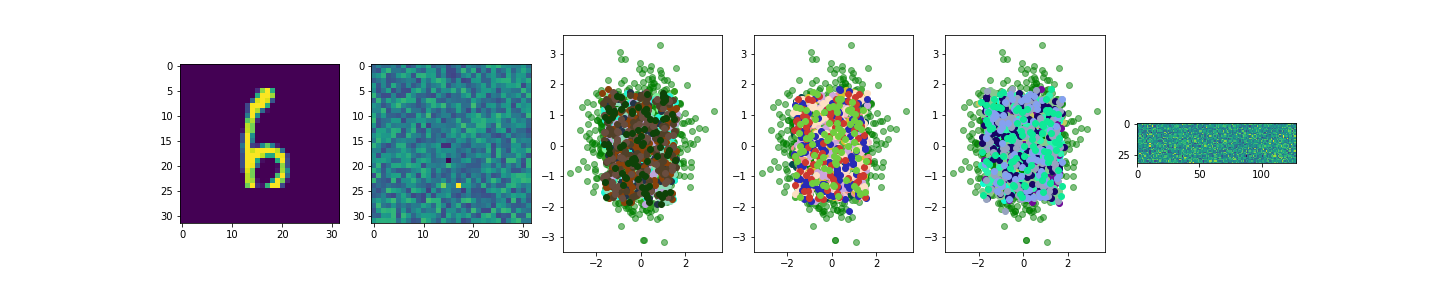

#-  std [0.11688656 0.13395071 0.15454523 ... 0.1873109  0.16748492 0.13928887] 0.41437387

loss:0.6960, logdet:0.7288 pz:-1.4248 
latentstd:0.6582  recon_loss:0.0033
#-  std [0.204996   0.27143064 0.28470224 ... 0.29484504 0.28557548 0.21636052] 0.7517841

loss:-0.1313, logdet:1.4917 pz:-1.3605 
latentstd:0.7794  recon_loss:0.0033
#-  std [0.27004167 0.3685174  0.37938172 ... 0.367459   0.37350672 0.287821  ] 0.88038236

loss:-0.2657, logdet:1.7047 pz:-1.4389 
latentstd:0.8757  recon_loss:0.0032
#-  std [0.30922273 0.39292237 0.39951307 ... 0.40100712 0.40134215 0.30989063] 0.84948003

loss:-0.3517, logdet:1.7916 pz:-1.4399 
latentstd:0.8780  recon_loss:0.0033
#-  std [0.42274123 0.51440144 0.5204278  ... 0.49933434 0.5003174  0.40784135] 0.8828324

loss:-0.5996, logdet:1.9934 pz:-1.3938 
latentstd:0.8695  recon_loss:0.0034
#-  std [0.6350726  0.7470554  0.7503544  ... 0.7684519  0.78403395 0.6572931 ] 0.91433847

loss:-0.8769, logdet:2.2543 pz:-1.3773 
latentstd:0.9220  recon_loss:0.

#-  std [0.9422615  1.0200005  0.9749266  ... 1.0040827  1.0231403  0.93945026] 1.0198816

loss:-1.1852, logdet:2.5917 pz:-1.4066 
latentstd:0.9792  recon_loss:0.2106
#-  std [0.946726   0.9808455  0.96017295 ... 1.0027202  0.9543065  0.91487026] 0.99842155

loss:-1.1431, logdet:2.5684 pz:-1.4252 
latentstd:0.9884  recon_loss:0.4509
#-  std [0.9455145 0.9647761 0.981767  ... 1.0077695 1.0203912 0.9308033] 0.9846659

loss:-1.1642, logdet:2.6104 pz:-1.4462 
latentstd:1.0067  recon_loss:0.2340
#-  std [0.93601507 0.994159   1.0305985  ... 0.9925247  0.99406403 0.91086316] 1.0001411

loss:-1.1809, logdet:2.6088 pz:-1.4279 
latentstd:0.9966  recon_loss:0.2966
#-  std [0.94603914 1.0023471  1.0161095  ... 0.9935379  1.03888    0.9143608 ] 1.0108869

loss:-1.1685, logdet:2.5859 pz:-1.4174 
latentstd:0.9876  recon_loss:0.3628
#-  std [0.9327126  1.0074751  0.97483236 ... 0.99073815 1.0017294  0.907901  ] 0.9804532

loss:-1.2044, logdet:2.6248 pz:-1.4204 
latentstd:0.9896  recon_loss:0.4421
#- 

In [ ]:
%matplotlib notebook
#del  latent, latentstd,log_pz,logdet

#optim = Adam(net.parameters(), lr=0.001)#, betas=(0.1,0.9))
optim = Adamax(net.parameters(), lr=0.003)
fig,(ax,ax_, ax2, ax3, ax4, ax5) = plt.subplots(1,6,figsize=(20,4))
axim = None
axscatter = None
fig.canvas.draw()

use_normal = True
test_aucs = []
train_aucs = []
pred_losses = []
pzes = []
logdets = []
losses = []
mis = []
latent_numpys =[]
#def torchSigWMW( target,pred, beta=8):    
#    mask = target.type(torch.cuda.ByteTensor)
#    x = torch.masked_select(pred, 1+(-1)*mask).view(1,-1)
#    y = torch.masked_select(pred, mask).view(-1,1)
#    xn = x.expand(y.size(0), x.size(1))
#    yn = y.expand(y.size(0), x.size(1))
#    ur = torch.sigmoid(-beta*(xn-yn))
#    return torch.sum(ur) / torch.sum(target) / torch.sum(1-target)

#def criterion(pred, target):
    # return ((pred - (target * dist * 2 - dist)) ** 2).mean() 
#    return torchSigWMW(target, pred)


for epoch in tqdm(range(0,200)):  
    itercount = 0
    for inp, _ in tqdm(trainloader): 
        #fig,(ax,ax2) = plt.subplots(1,2,figsize=(18,8))
        net.train()
        optim.zero_grad()
        inp = inp.cuda()
        latent, logdet = net(inp + (torch.rand_like(inp).cuda() - 0.5) / ( n_bins), #+ torch.randn_like(inp).cuda() / (2 ** n_bins), 
                             return_logdet=True, num_logdet_iter=5) 
        #for lt in latent:
        #    print(lt.shape, 'latent shape')
        #input() 
        latent = latent.flatten(1)#torch.cat([l.flatten(1) for l in latent], dim=1)
        #print(latent.shape)
        #input()
        #logdet /= inp.shape[2] * inp.shape[3]
        
        with torch.no_grad():
            latentstd = torch.mean(latent.std(dim=0))
        #    print(latent.std(dim=0))
        #    pred = net(latent[:4].view(-1, 64, 4, 4), reverse=True, reverse_iterations=100)
            
        #train_exmp = inp[0].cpu().detach().numpy().reshape((32, 32))
        #train_recon_exmp = pred[0].cpu().detach().numpy().reshape((32, 32))
        #ax.imshow(train_exmp)
        #ax_.imshow(train_recon_exmp)
        #fig.canvas.draw()
        

        #pz = 0
        #for l in latent:
        #    pz += -((l.view(inp.shape[0], -1)) ** 2).sum(dim=1) / 2 
        log_pz = gaussian.log_prob(latent).sum(1)
        
        #log_pz = log_pz.mean()
        #log_pz /= inp.shape[2] * inp.shape[3]
        #print(logdet.shape)
        #print(log_pz.shape)
        h_x_w = inp.shape[2] * inp.shape[3]
        log_px = log_pz + logdet
        mi = gaussian.log_prob(latent[:, :-3]).sum(1) + logdet
        
        loss = - log_px # - lambda_mi * mi# minimize neg log likelihood
        loss = loss.mean() / h_x_w 
        #print(latentstd.shape)
        #print(recon_loss.shape)
       
        loss.backward()
         
        
        #(- logdet-pz).backward()

        pzes.append((log_pz.mean() / h_x_w).item())
        logdets.append((logdet.mean()/h_x_w).item())
        mis.append((mi.mean()/h_x_w).item())
        losses.append(loss.item())
        torch.nn.utils.clip_grad_norm_(net.parameters(), 1.0)
        optim.step()
        with torch.no_grad():
          if itercount % 10 == 0:
            net.eval()
            latents = []
            for test_batch, test_label in testloader:
                test_batch = test_batch.cuda()
                latent = net(test_batch + (torch.rand_like(test_batch).cuda() - 0.5) / ( n_bins), 
                             return_logdet=False)
                break

            with torch.no_grad():
                #pred = net([l[:1] for l in latent], reverse=True)
                pred = net(latent[:4], reverse=True, reverse_iterations=100)
            
            latent_numpy = latent.flatten(1).detach().cpu().numpy()
            test_label = test_label.cpu().numpy()[:1000]
            
         
            #print(latent_numpy.shape)
            print("#-  std", latent_numpy.std(axis=0), latent_numpy.std(axis=0).mean())
            print()
            #input()
            recon_loss = F.mse_loss(test_batch[:1].flatten(), pred[:1].flatten())
            #if itercount >0:
            print ('loss:{:.4f}, logdet:{:.4f} pz:{:.4f} '.format(
                    loss.item(), (logdet.mean()/h_x_w).item(), (log_pz.mean() / h_x_w).item()))
            print ('latentstd:{:.4f}  recon_loss:{:.4f}'.format(latentstd.item(),  recon_loss.item()))


            pred_np = pred[0].cpu().detach().numpy().reshape((32,32))
            inp_np = test_batch[0].cpu().detach().numpy().reshape((32,32))
            disp = inp_np #np.concatenate([pred_np, inp_np], axis=1)
            if axim:
                axim.set_data(disp)
            else:
                axim = ax.imshow(disp)
            ax_.imshow(pred_np)
            with torch.no_grad():
                #pred = net([l[:1] for l in latent], reverse=True)
                latent_samples = gaussian.sample((4, 64, 4, 4)).cuda()
                samples = net(latent_samples, reverse=True)
                samples = samples.cpu().detach().numpy().reshape(-1, 32, 32)
                disp = np.concatenate([sample for sample in samples], axis=1)
                ax5.imshow(disp)
                
                

            ax2.clear()
            ax2.scatter(normal_np[:1000,0], normal_np[:1000,1], c='g', alpha=0.5)
            ax3.clear()
            ax3.scatter(normal_np[:1000,0], normal_np[:1000,1], c='g', alpha=0.5)
            ax4.clear()
            ax4.scatter(normal_np[:1000,0], normal_np[:1000,1], c='g', alpha=0.5)
            for num in range(10):
                ax2.scatter(latent_numpy[:1000,-1][test_label == num], latent_numpy[:1000,-2][test_label == num],  c=np.random.rand(3))
            for num in range(10):
                ax3.scatter(latent_numpy[:1000,-1][test_label == num], latent_numpy[:1000,-3][test_label == num],  c=np.random.rand(3)) 
            for num in range(10):
                ax4.scatter(latent_numpy[:1000,-2][test_label == num], latent_numpy[:1000,-3][test_label == num],  c=np.random.rand(3)) 
                
            #plt.show()
            fig.canvas.draw()
            latent_numpys.append(latent_numpy)
        itercount += 1
        del log_pz,  logdet, latent, latentstd
    #with torch.no_grad():
    #    for name, param in net.named_parameters():
    #        if '.weight' in name:
    #            param /= torch.sqrt((param ** 2).sum())

In [ ]:
latent_numpys = np.array(latent_numpys)

In [ ]:
dists = torch.from_numpy(np.array([[dist,-dist], [dist, dist], [-dist, dist], [-dist,-dist]]).astype(np.float32)).cuda()

In [ ]:
latent_numpys.shape

In [ ]:
latent_numpys = latent_numpys.reshape((-1,80,2560,2))

In [ ]:
latent_numpy = latent_numpys[0,-1]

In [ ]:
latent_numpy.shape

In [ ]:
np.std(latent_numpy[np.logical_and(latent_numpy[:,0] > 0, latent_numpy[:,1] < 0)], axis=0)

In [ ]:
np.mean(latent_numpy[np.logical_and(latent_numpy[:,0] < 0, latent_numpy[:,1] < 0)], axis=0)

In [ ]:
%matplotlib notebook
fig,ax =  plt.subplots(1,1,figsize=(8,8))
def scroll(event):
    global i, latent_numpys
    oldi = i
    if event.key == 'e':
        i -= 1
    elif event.key =='d':
        i += 1
    if i < 0: i = 0
    if i >= len(latent_numpys[0]) - 0: i = len(latent_numpys[0]) - 1
    if oldi != i:
        ax.clear()
        latent_numpy = latent_numpys[0][i][-1]
        
        ax.clear()
        _ = ax.hist(latent_numpys[0][i][:,1], bins=100, density=True)
        _ = ax.hist(normal_np[:,1], bins=100, density=True)
        
        fig.canvas.draw()
        #ax.set_xlim(-3,3)
        #ax.set_ylim(-3,3)


cid1 = fig.canvas.mpl_connect('key_press_event', scroll)
i = 0
latent_numpy = latent_numpys[0][i][-1]
ax.clear()
_ = ax.hist(latent_numpys[0][i][:,1], bins=100, density=True)
_ = ax.hist(normal_np[:,1], bins=100, density=True)


fig.canvas.draw()
#ax.set_xlim(-3,3)
#ax.set_ylim(-3,3)


In [ ]:
%matplotlib notebook
fig,ax =  plt.subplots(1,1,figsize=(8,8))
def scroll(event):
    global i, latent_numpys
    oldi = i
    if event.key == 'e':
        i -= 1
    elif event.key =='d':
        i += 1
    if i < 0: i = 0
    if i >= len(latent_numpys[0]) - 0: i = len(latent_numpys[0]) - 1
    if oldi != i:
        ax.clear()
        latent_numpy = latent_numpys[0,i]
        
        ax.clear()
        ax.scatter(normal_np[:,0], normal_np[:,1], c='g') 
        ax.scatter(latent_numpy[:500,0], latent_numpy[:500,1],  c='r')  
        fig.canvas.draw()
        #ax.set_xlim(-3,3)
        #ax.set_ylim(-3,3)


cid1 = fig.canvas.mpl_connect('key_press_event', scroll)
i = 0
latent_numpy = latent_numpys[0,i]
ax.clear()
ax.scatter(normal_np[:,0], normal_np[:,1], c='g')
ax.scatter(latent_numpy[:500,0], latent_numpy[:500,1],  c='r')  
fig.canvas.draw()
#ax.set_xlim(-3,3)
#ax.set_ylim(-3,3)

In [ ]:
%matplotlib inline
plt.plot(range(len(losses[:])), losses[:])

In [ ]:
%matplotlib inline
plt.plot(range(len(logdets[:])), logdets[:])

In [ ]:
%matplotlib inline
plt.plot(range(len(pzes[250:])), pzes[250:])